In [1]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnan, when, count
from pyspark.sql.types import DoubleType, StringType
from pyspark.ml.feature import Imputer, StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, RandomForestRegressor
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Initialize Spark session with more explicit configuration
try:
    spark = SparkSession.builder \
    .appName("TaxiFarePrediction") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.executor.cores", "4") \
    .config("spark.sql.shuffle.partitions", "50") \
    .config("spark.default.parallelism", "50") \
    .config("spark.memory.offHeap.enabled", "true") \
    .config("spark.memory.offHeap.size", "4g") \
    .getOrCreate()
    
    # Set log level to ERROR to reduce verbosity
    spark.sparkContext.setLogLevel("ERROR")
except Exception as e:
    print(f"Error initializing Spark: {e}")
    raise


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/21 22:51:59 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# Load the CSV file
df = spark.read.csv("/kaggle/input/taxiprovider-trips-dataset/data-taxi-with-provider.csv", header=True, inferSchema=True)
df.printSchema()
df.show(5)

# Sample to 0.1% of the data
df = df.sample(fraction=0.001, seed=42).repartition(20)

root
 |-- OBJECTID: integer (nullable = true)
 |-- TRIPTYPE: string (nullable = true)
 |-- FAREAMOUNT: double (nullable = true)
 |-- GRATUITYAMOUNT: double (nullable = true)
 |-- SURCHARGEAMOUNT: double (nullable = true)
 |-- EXTRAFAREAMOUNT: double (nullable = true)
 |-- TOLLAMOUNT: double (nullable = true)
 |-- TOTALAMOUNT: double (nullable = true)
 |-- PAYMENTTYPE: integer (nullable = true)
 |-- ORIGINCITY: string (nullable = true)
 |-- ORIGINSTATE: string (nullable = true)
 |-- ORIGINZIP: integer (nullable = true)
 |-- DESTINATIONCITY: string (nullable = true)
 |-- DESTINATIONSTATE: string (nullable = true)
 |-- DESTINATIONZIP: string (nullable = true)
 |-- MILEAGE: double (nullable = true)
 |-- DURATION: double (nullable = true)
 |-- ORIGIN_BLOCK_LATITUDE: double (nullable = true)
 |-- ORIGIN_BLOCK_LONGITUDE: double (nullable = true)
 |-- ORIGIN_BLOCKNAME: string (nullable = true)
 |-- DESTINATION_BLOCK_LAT: string (nullable = true)
 |-- DESTINATION_BLOCK_LONG: double (nullable = 

In [4]:
# Identify numerical and categorical features
numerical_cols = [c for c, t in df.dtypes if t in ['int', 'double', 'float'] and c not in ['Fare amount', 'Total amount']]
categorical_cols = [c for c, t in df.dtypes if t == 'string' and c != 'provider']
target_col = 'FAREAMOUNT'
print(f"Numerical columns: {numerical_cols}")
print(f"Categorical columns: {categorical_cols}")

Numerical columns: ['OBJECTID', 'FAREAMOUNT', 'GRATUITYAMOUNT', 'SURCHARGEAMOUNT', 'EXTRAFAREAMOUNT', 'TOLLAMOUNT', 'TOTALAMOUNT', 'PAYMENTTYPE', 'ORIGINZIP', 'MILEAGE', 'DURATION', 'ORIGIN_BLOCK_LATITUDE', 'ORIGIN_BLOCK_LONGITUDE', 'DESTINATION_BLOCK_LONG']
Categorical columns: ['TRIPTYPE', 'ORIGINCITY', 'ORIGINSTATE', 'DESTINATIONCITY', 'DESTINATIONSTATE', 'DESTINATIONZIP', 'ORIGIN_BLOCKNAME', 'DESTINATION_BLOCK_LAT', 'DESTINATION_BLOCKNAME', 'AIRPORT', 'ORIGINDATETIME_TR', 'DESTINATIONDATETIME_TR', 'PROVIDERNAME']


In [5]:
# Visualize numerical features
for col_name in numerical_cols:
    hist_data = df.select(col_name).na.drop().rdd.flatMap(lambda x: x).histogram(20)
    plt.figure(figsize=(8, 6))
    plt.bar(hist_data[0][:-1], hist_data[1], width=(hist_data[0][1] - hist_data[0][0]))
    plt.title(f'Distribution of {col_name}')
    plt.xlabel(col_name)
    plt.ylabel('Count')
    plt.savefig(f'{col_name}_hist.png')
    plt.close()


In [6]:
# Visualize categorical features
for col_name in categorical_cols:
    counts = df.groupBy(col_name).count().orderBy('count', ascending=False).limit(10).toPandas()
    plt.figure(figsize=(8, 6))
    sns.barplot(x=col_name, y='count', data=counts)
    plt.title(f'Frequency of {col_name}')
    plt.xticks(rotation=45)
    plt.savefig(f'{col_name}_bar.png')
    plt.close()


In [7]:
# Check and visualize missing values
missing = df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns])
missing.show()
missing_pd = missing.toPandas().T
missing_pd.columns = ['missing_count']
plt.figure(figsize=(10, 6))
missing_pd['missing_count'].plot(kind='bar')
plt.title('Missing Values per Column')
plt.ylabel('Count')
plt.savefig('missing_values.png')
plt.close()

+--------+--------+----------+--------------+---------------+---------------+----------+-----------+-----------+----------+-----------+---------+---------------+----------------+--------------+-------+--------+---------------------+----------------------+----------------+---------------------+----------------------+---------------------+-------+-----------------+----------------------+------------+
|OBJECTID|TRIPTYPE|FAREAMOUNT|GRATUITYAMOUNT|SURCHARGEAMOUNT|EXTRAFAREAMOUNT|TOLLAMOUNT|TOTALAMOUNT|PAYMENTTYPE|ORIGINCITY|ORIGINSTATE|ORIGINZIP|DESTINATIONCITY|DESTINATIONSTATE|DESTINATIONZIP|MILEAGE|DURATION|ORIGIN_BLOCK_LATITUDE|ORIGIN_BLOCK_LONGITUDE|ORIGIN_BLOCKNAME|DESTINATION_BLOCK_LAT|DESTINATION_BLOCK_LONG|DESTINATION_BLOCKNAME|AIRPORT|ORIGINDATETIME_TR|DESTINATIONDATETIME_TR|PROVIDERNAME|
+--------+--------+----------+--------------+---------------+---------------+----------+-----------+-----------+----------+-----------+---------+---------------+----------------+--------------+---

In [8]:
# Handle missing values
imputer = Imputer(inputCols=numerical_cols, outputCols=numerical_cols).setStrategy('mean')
df = imputer.fit(df).transform(df)
for col_name in categorical_cols:
    df = df.withColumn(col_name, when(col(col_name).isNull(), 'unknown').otherwise(col(col_name)))
df = df.dropna(subset=[target_col, 'TOTALAMOUNT'])

In [9]:
# Remove duplicates
df = df.dropDuplicates()

In [10]:
# Filter outliers
df = df.filter((col(target_col) > 0) & (col(target_col) < 1000))
for col_name in numerical_cols:
    quantiles = df.approxQuantile(col_name, [0.01, 0.99], 0.0)
    df = df.filter((col(col_name) >= quantiles[0]) & (col(col_name) <= quantiles[1]))

In [11]:
# Visualize data after cleaning
for col_name in numerical_cols:
    hist_data = df.select(col_name).rdd.flatMap(lambda x: x).histogram(20)
    plt.figure(figsize=(8, 6))
    plt.bar(hist_data[0][:-1], hist_data[1], width=(hist_data[0][1] - hist_data[0][0]))
    plt.title(f'Distribution of {col_name} After Cleaning')
    plt.xlabel(col_name)
    plt.ylabel('Count')
    plt.savefig(f'{col_name}_hist_cleaned.png')
    plt.close()

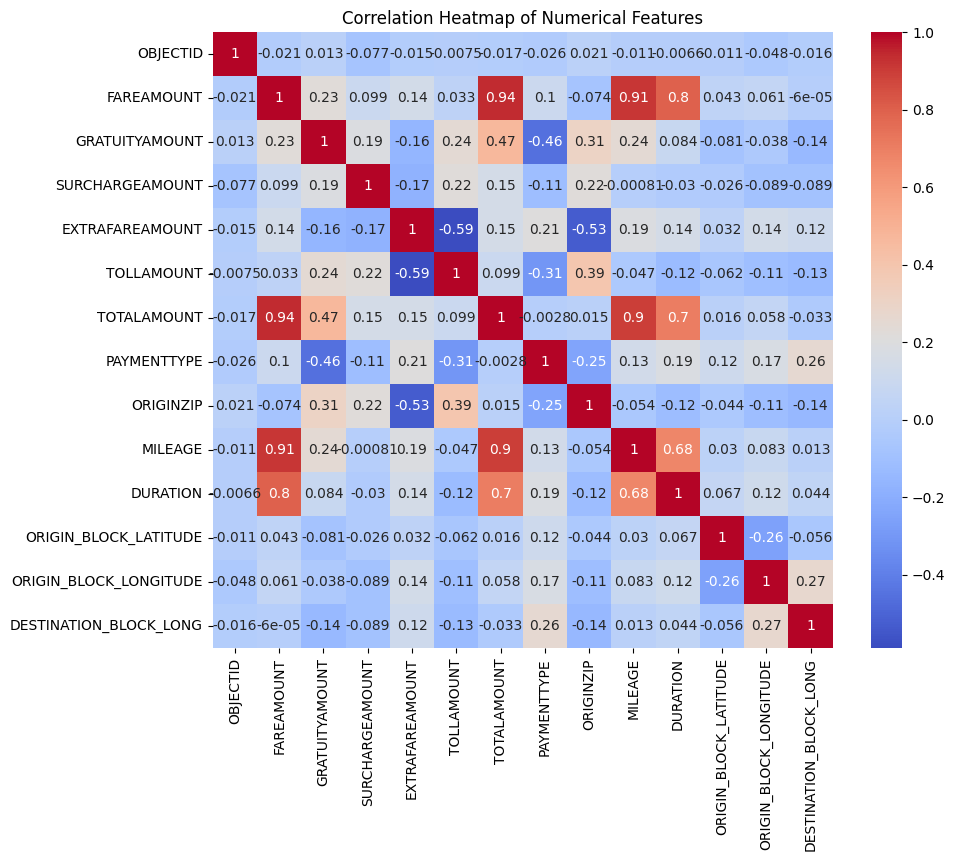

In [12]:
# Correlation heatmap for numerical features
num_df = df.select(numerical_cols).toPandas()
plt.figure(figsize=(10, 8))
sns.heatmap(num_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Numerical Features')
plt.savefig('correlation_heatmap.png')
plt.show()
plt.close()

In [13]:
# Define pipeline stages
indexers = [StringIndexer(inputCol=c, outputCol=c+"_index") for c in categorical_cols]
encoders = [OneHotEncoder(inputCol=c+"_index", outputCol=c+"_encoded") for c in categorical_cols]
assembler = VectorAssembler(inputCols=[c+"_encoded" for c in categorical_cols] + numerical_cols, outputCol="features_unscaled")
scaler = StandardScaler(inputCol="features_unscaled", outputCol="features", withMean=True, withStd=True)

# Create and run pipeline
pipeline = Pipeline(stages=indexers + encoders + [assembler, scaler])
df_transformed = pipeline.fit(df).transform(df)

In [14]:
# Split data into train, validation, and test sets
train_df, val_df, test_df = df_transformed.randomSplit([0.6, 0.2, 0.2], seed=42)


In [15]:
# Define evaluators
evaluator_rmse = RegressionEvaluator(labelCol=target_col, predictionCol="prediction", metricName="rmse")
evaluator_mae = RegressionEvaluator(labelCol=target_col, predictionCol="prediction", metricName="mae")
evaluator_r2 = RegressionEvaluator(labelCol=target_col, predictionCol="prediction", metricName="r2")


In [16]:
# Linear Regression with Cross-Validation
lr = LinearRegression(featuresCol="features", labelCol=target_col)
lr_paramGrid = ParamGridBuilder() \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .addGrid(lr.regParam, [0.01, 0.1]) \
    .build()
lr_cv = CrossValidator(estimator=lr, estimatorParamMaps=lr_paramGrid, evaluator=evaluator_rmse, numFolds=3)
lr_model = lr_cv.fit(train_df)

In [17]:
# Decision Tree with Cross-Validation
dt = DecisionTreeRegressor(featuresCol="features", labelCol=target_col)
dt_paramGrid = ParamGridBuilder().addGrid(dt.maxDepth, [5, 10]).build()
dt_cv = CrossValidator(estimator=dt, estimatorParamMaps=dt_paramGrid, evaluator=evaluator_rmse, numFolds=3)
dt_model = dt_cv.fit(train_df)

In [18]:
# Random Forest with Cross-Validation
rf = RandomForestRegressor(featuresCol="features", labelCol=target_col)
rf_paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [20, 50]) \
    .addGrid(rf.maxDepth, [5, 10]) \
    .build()
rf_cv = CrossValidator(estimator=rf, estimatorParamMaps=rf_paramGrid, evaluator=evaluator_rmse, numFolds=3)
rf_model = rf_cv.fit(train_df)

In [19]:
# Evaluate models on validation set
models = {'Linear Regression': lr_model, 'Decision Tree': dt_model, 'Random Forest': rf_model}
results = {}
for name, model in models.items():
    preds = model.transform(val_df)
    rmse = evaluator_rmse.evaluate(preds)
    mae = evaluator_mae.evaluate(preds)
    r2 = evaluator_r2.evaluate(preds)
    results[name] = {'RMSE': rmse, 'MAE': mae, 'R2': r2}
    print(f'{name} - RMSE: {rmse}, MAE: {mae}, R2: {r2}')


Linear Regression - RMSE: 0.09729422938003071, MAE: 0.07494933061777963, R2: 0.9998190104839868


Decision Tree - RMSE: 0.7839673024996905, MAE: 0.374936421966172, R2: 0.9882489911657812


Random Forest - RMSE: 0.8147368441938795, MAE: 0.3709871833915692, R2: 0.9873084704135879


<Figure size 1000x600 with 0 Axes>

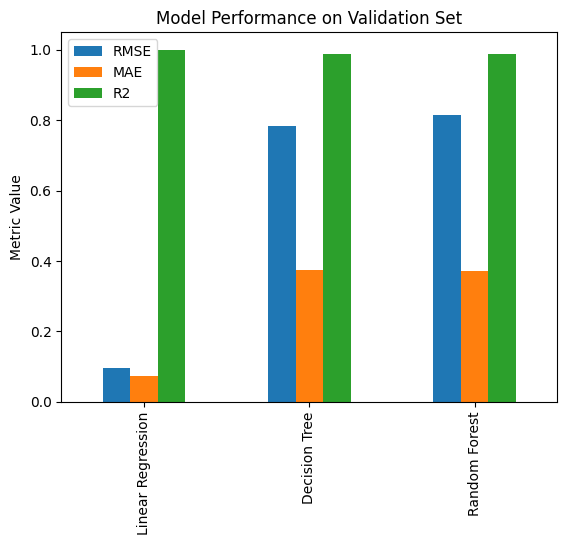

In [20]:
# Visualize model comparison
results_df = pd.DataFrame(results).T
plt.figure(figsize=(10, 6))
results_df.plot(kind='bar')
plt.title('Model Performance on Validation Set')
plt.ylabel('Metric Value')
plt.savefig('model_comparison.png')
plt.show()
plt.close()

In [21]:
# Select best model (assuming Random Forest performs best) and evaluate on test set
best_model = rf_model
test_preds = best_model.transform(test_df)
test_rmse = evaluator_rmse.evaluate(test_preds)
test_mae = evaluator_mae.evaluate(test_preds)
test_r2 = evaluator_r2.evaluate(test_preds)
print(f'Best Model (Random Forest) - Test RMSE: {test_rmse}, MAE: {test_mae}, R2: {test_r2}')


Best Model (Random Forest) - Test RMSE: 1.2915868014993153, MAE: 0.5111952619617008, R2: 0.9746353196126426


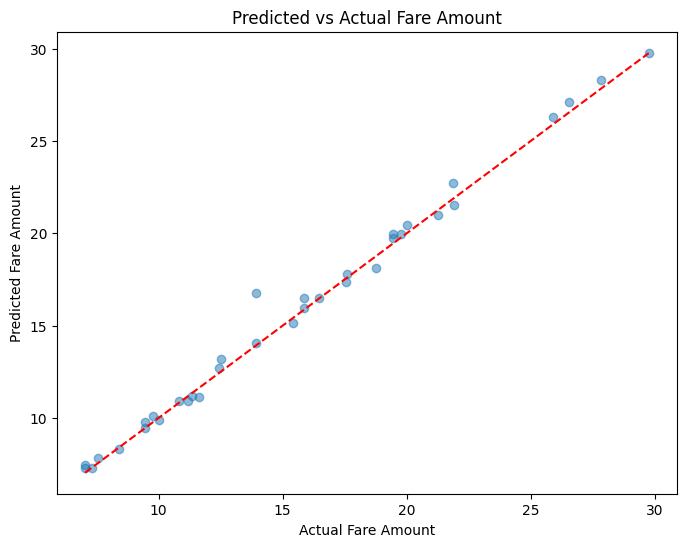

In [22]:
# Plot predicted vs actual
test_pd = test_preds.select(target_col, 'prediction').sample(fraction=0.1).toPandas()
plt.figure(figsize=(8, 6))
plt.scatter(test_pd[target_col], test_pd['prediction'], alpha=0.5)
plt.plot([test_pd[target_col].min(), test_pd[target_col].max()], [test_pd[target_col].min(), test_pd[target_col].max()], 'r--')
plt.xlabel('Actual Fare Amount')
plt.ylabel('Predicted Fare Amount')
plt.title('Predicted vs Actual Fare Amount')
plt.savefig('pred_vs_actual.png')
plt.show()
plt.close()

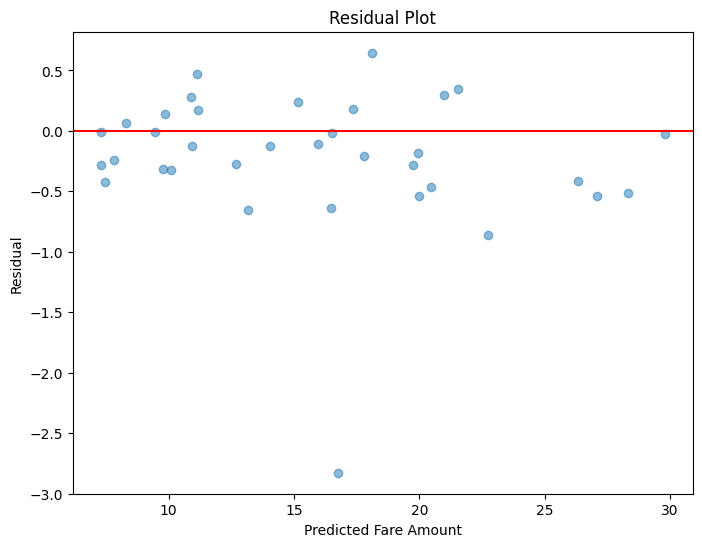

In [23]:
# Residual plot
test_pd['residual'] = test_pd[target_col] - test_pd['prediction']
plt.figure(figsize=(8, 6))
plt.scatter(test_pd['prediction'], test_pd['residual'], alpha=0.5)
plt.axhline(0, color='red')
plt.xlabel('Predicted Fare Amount')
plt.ylabel('Residual')
plt.title('Residual Plot')
plt.savefig('residual_plot.png')
plt.show()
plt.close()

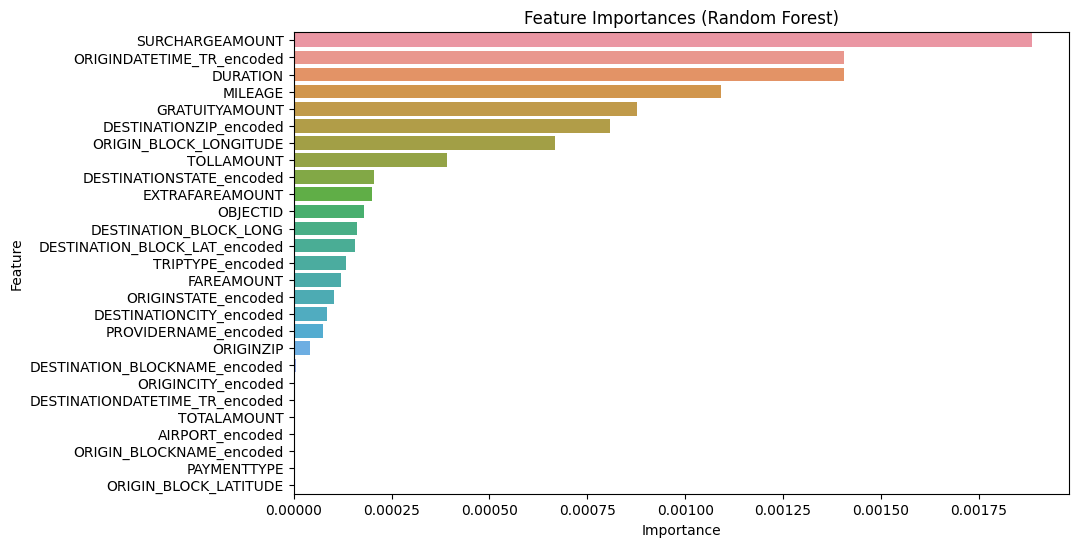

In [24]:
# Feature importances for Random Forest
importances = best_model.bestModel.featureImportances.toArray()
# Simplified feature names (actual names depend on dataset)
feature_names = numerical_cols + [f'{c}_encoded' for c in categorical_cols]
feat_imp_df = pd.DataFrame({'Importance': importances})
feat_imp_df['Feature'] = pd.Series(feature_names).reindex(range(len(importances)))
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df.sort_values('Importance', ascending=False))
plt.title('Feature Importances (Random Forest)')
plt.savefig('feature_importances.png')
plt.show()
plt.close()

In [25]:
# Stop Spark session
spark.stop()